# Notebook for Denoising SPECT Images

In this notebook we will try to create a neural network that will denoise simulated SPECT images.

First we import some libraries:

In [1]:
%matplotlib inline
from fastai.basics import *
from fastai.vision import *
import fastai
from fastai.callbacks import *
from fastai.vision.gan import *
import random
import os

## (1) Making directories and checking the images.

In [2]:
path = Path('proj_20_200')

#creates the path in which the folders of the images are in.

In [3]:
path.ls()

#shows the path where the low- and high-count images are put.

[PosixPath('proj_20_200/low_count'),
 PosixPath('proj_20_200/GATE_proj_res'),
 PosixPath('proj_20_200/high_count')]

In [4]:
path_low = path/'low_count'
path_high = path/'high_count'

#creates two paths to the image-directories

The following line of code makes two lists: 
* A list of high-resolution images
* A list of low-resolution images


In [5]:
high_images = get_image_files(path_high)   #high res images list
low_images = get_image_files(path_low)     #low res image list
print('Length of low count is', len(low_images))
print('Length of high counts is', len(high_images))

Length of low count is 513
Length of high counts is 513


## Clean data

In [6]:
high_str = [0]*len(high_images)
for i in  range(0,len(high_images)):
    high_str[i] = os.path.basename(high_images[i]);    
low_str = [0]*len(low_images)
for i in  range(0,len(low_images)):
    low_str[i] = os.path.basename(low_images[i]);    
common_str = [x for x in low_str if x in high_str]

In [7]:
for i in  range(0,len(high_images)):
    if os.path.basename(high_images[i]) not in common_str:
        os.remove(high_images[i])
for i in  range(0,len(low_images)):
    if os.path.basename(low_images[i]) not in common_str:
        os.remove(low_images[i])

## Creating the Databunch

In [8]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_high/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

#     data.c = 3
    return data

src = ImageImageList.from_folder(path_low).split_by_rand_pct(0.1, seed=42)

data_gen = get_data(bs=4,size=512)

#this creates the databunch.

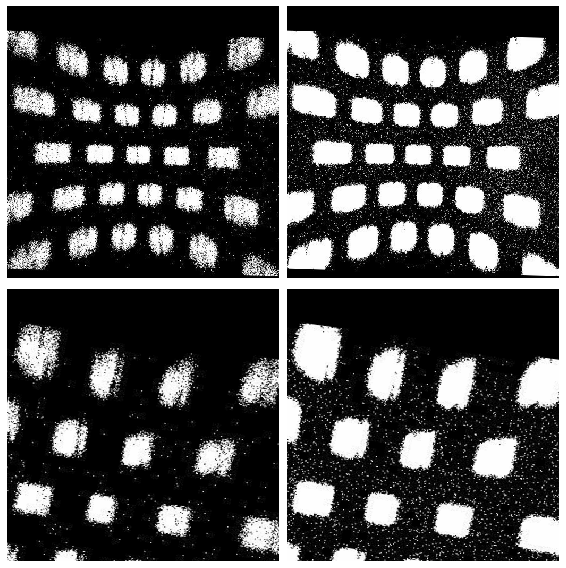

In [9]:
data_gen.show_batch(2)

#this will show 4 datasets of high- and low-count images.

## Simple Generator

In [10]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [11]:
def create_gen_learner(wd, data_gen, y_range, loss_gen):
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

arch = models.resnet34
learn_gen = create_gen_learner(wd, data_gen, y_range, loss_gen)#.to_fp16()

Here we create a generator. The generator is trained using transfer learning so it starts with a basic understanding of what images look like.

In [12]:
learn_gen.fit_one_cycle(2, pct_start=0.8)
# learn_gen.unfreeze()
# learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.409064,0.564312,01:00
1,0.290296,0.432809,00:54


In [13]:
learn_gen.save('stage-1')
# learn_gen.load('stage-1');

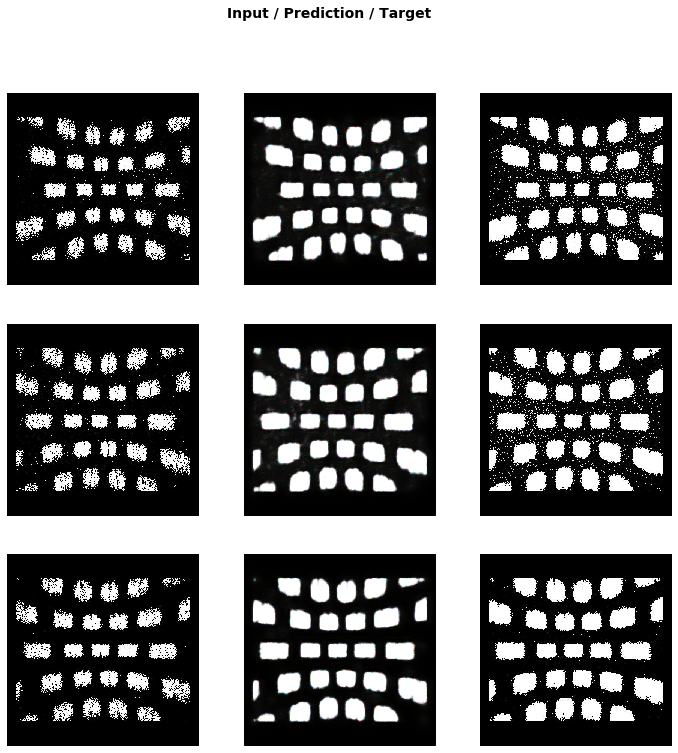

In [14]:
learn_gen.show_results(rows=3)

## Putting your model in production
https://docs.fast.ai/tutorial.inference.html

For production, we need to export the model/learner to use later

In [15]:
learn_gen.export('trained_model.pkl')

Import libraries if they have not been imported

In [25]:
%matplotlib inline
from fastai.basics import *
from fastai.vision import *
import fastai
from fastai.callbacks import *
from fastai.vision.gan import *
from matplotlib import pyplot as plt
import numpy as np

In [26]:
learn_gen = load_learner('proj_20_200/low_count', 'trained_model.pkl')

Inference/prediction will be done on CPU, not GPU!

In [27]:
defaults.device = torch.device('cpu')

In [48]:
# img = open_image('proj_20_200/low_count/proj_1a_bp1.jpg')

In [49]:
# preds,_,_ = learn_gen.predict(img)

In [30]:
# for det in ['a', 'b', 'c']:
#     for bp in range(1, 9):
#         img = open_image('proj_20_200/low_count/proj_1%s_bp%d.jpg' % (det, bp))
#         preds,_,_ = learn_gen.predict(img)
#         preds = preds.save('proj_20_200/preds/proj_1%s_bp%d.jpg' % (det, bp))

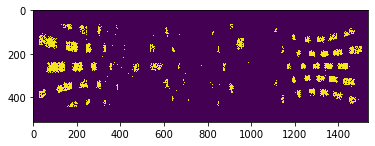

In [50]:
proj = np.fromfile('proj_test/GATE_proj_res/proj_newbgmeasurement_n20_nosca_nobgn_0', dtype='int32')
proj = np.transpose(proj.reshape([1536,512]))
plt.imshow(proj)

In [51]:
proj1 = proj[:,0:512];
proj1 = pil2tensor(proj1, dtype=np.int32)
proj1 = Image(proj1)
proj1,_,_ = learn_gen.predict(proj1)

proj2 = proj[:,512:512*2];
proj2 = pil2tensor(proj2, dtype=np.int32)
proj2 = Image(proj2)
proj2,_,_ = learn_gen.predict(proj2)

proj3 = proj[:,512*2:512*3];
proj3 = pil2tensor(proj3, dtype=np.int32)
proj3 = Image(proj3)
proj3,_,_ = learn_gen.predict(proj3)

In [47]:
proj = [proj1; proj2; proj3]

SyntaxError: invalid syntax (<ipython-input-47-a693af85b10d>, line 1)

In [54]:
proj.max()

1097859072